In [30]:
import keras
import cv2 
import fnmatch
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from keras.regularizers import l2
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import SeparableConv2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import Adam
from keras.applications import NASNetLarge
import tensorflow
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
 

In [4]:
image = glob.glob('/Users/kavyashreya/Documents/4class/**/*.tif', recursive=True)

In [5]:
X=list()
Y1=list()

class1 = '*b***.tif'
class2 = '*is***.tif'
class3 = '*iv***.tif'
class4 = '*n***.tif'
classOne = fnmatch.filter(image, class1)
classTwo = fnmatch.filter(image, class2)
classThree = fnmatch.filter(image, class3)
classFour = fnmatch.filter(image, class4)
lowerIndex=0
upperIndex = len(image)
 #entering loop
for img in image[lowerIndex:upperIndex]:
        if img in classTwo:
            Y1.append(2)
        elif img in classOne:
            Y1.append(1)
        elif img in classThree:
            Y1.append(3)
        elif img in classFour:
            Y1.append(4)   

In [5]:
len(Y1)

400

In [6]:
train_df=pd.DataFrame()
train_df['images']=image
train_df['label']=Y1
train_df.head()

,images,label
0,/Users/kavyashreya/Documents/4class/InSitu/is0...,2
1,/Users/kavyashreya/Documents/4class/InSitu/is0...,2
2,/Users/kavyashreya/Documents/4class/InSitu/is0...,2
3,/Users/kavyashreya/Documents/4class/InSitu/is0...,2
4,/Users/kavyashreya/Documents/4class/InSitu/is0...,2


In [7]:
train_df['label'].value_counts()

4    100
3    100
2    100
1    100
Name: label, dtype: int64

In [25]:
WIDTH=331
HEIGHT=331
X2=list()
X1=list()
for img in train_df['images']:
    full_size_image = cv2.imread(img)
    aug=cv2.cvtColor(full_size_image,cv2.COLOR_BGR2HSV)
    aug=cv2.resize(aug, (WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC)
    #X2.append(cv2.resize(full_size_image, (WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC))
    X1.append(aug)

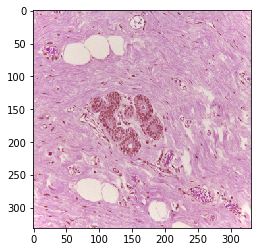

In [9]:
plt.imshow(X2[399])

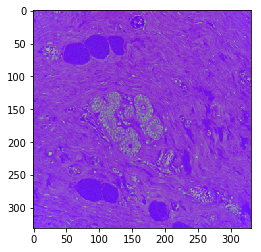

In [26]:
plt.imshow(X1[399])

In [10]:
full_size_image.shape

(1536, 2048, 3)

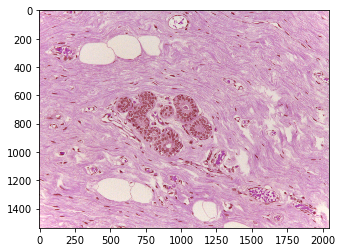

In [ ]:
plt.imshow(full_size_image)

In [27]:
Y_train = train_df['label']
X_train= np.array(X1)
X_train = X_train / 255.0

In [28]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train)


In [31]:
base_model=NASNetLarge(input_shape=(331,331,3), include_top=False, weights='imagenet', pooling='max')
model=Sequential()
model.add(base_model)
#model.add(Flatten())
model.add(Dense(2048, activation='elu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
for layer in base_model.layers:
  layer.trainable = False
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
scores=list()
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle=True)
for train_ix, test_ix in skf.split(X_train,Y_train):
   # select rows for train and test
   trainX, trainY, testX, testY = X_train[train_ix], Y_train[train_ix],X_train[test_ix], Y_train[test_ix]
   trainY = to_categorical(trainY, num_classes = 4)
   testY = to_categorical(testY, num_classes = 4)
   # fit model
   #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=5, restore_best_weights=True)
   #rlr =ReduceLROnPlateau(patience=2,monitor='val_loss')
   model.fit(trainX, trainY, epochs=12, batch_size=32, validation_data=(testX, testY), verbose=1)
   # evaluate model
   _, acc = model.evaluate(testX, testY, verbose=0)
   print('> %.3f' % (acc * 100.0))
   # stores scores
   scores.append(acc)
print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
